In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")
import kagglehub
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

# Load Dataset

In [2]:
american_electric_power = pd.read_csv("/kaggle/input/hourly-energy-consumption/AEP_hourly.csv")
american_electric_power.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# Preprocess Datetime

In [3]:
american_electric_power['Datetime'] = pd.to_datetime(american_electric_power['Datetime'])
american_electric_power['hour'] = american_electric_power['Datetime'].dt.hour
american_electric_power['day'] = american_electric_power['Datetime'].dt.day
american_electric_power['dayofweek'] = american_electric_power['Datetime'].dt.dayofweek
american_electric_power['month'] = american_electric_power['Datetime'].dt.month
american_electric_power['year'] = american_electric_power['Datetime'].dt.year
american_electric_power['is_weekend'] = american_electric_power['dayofweek'].isin([5, 6]).astype(int)
american_electric_power = american_electric_power.set_index("Datetime").sort_index()

# Standard Scaler Data

In [4]:
scaler = StandardScaler()
X = american_electric_power.drop(columns = ["AEP_MW"])
y = scaler.fit_transform(american_electric_power["AEP_MW"].values.reshape(-1, 1))

# Train Test Split

In [5]:
train_size = round(american_electric_power.shape[0] * 0.8)
train_df = american_electric_power[:train_size]
test_df = american_electric_power[train_size:]

scaler = StandardScaler()

X_train, y_train = train_df.drop(columns = "AEP_MW"), scaler.fit_transform(train_df["AEP_MW"].values.reshape(-1, 1))
X_test, y_test = test_df.drop(columns = "AEP_MW"), scaler.fit_transform(test_df["AEP_MW"].values.reshape(-1, 1))

# Linear Regression

In [6]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression()

In [7]:
y_pred = linear_regression.predict(X_test)

# ARIMA

In [8]:
arima = ARIMA(y_train, order = (2, 1, 2))
arima_fit = arima.fit()

In [9]:
arima_forecast = arima_fit.forecast(steps = len(y_pred))

# Evaluation

In [15]:
mae_lr = mean_absolute_error(y_pred, y_test)
mae_arima = mean_absolute_error(arima_forecast, y_test)

rmse_lr = mean_squared_error(y_pred, y_test, squared = False)
rmse_arima = mean_squared_error(arima_forecast, y_test, squared = False)

print(f"Linear Regression Mean Absolute Error: {mae_lr}")
print(f"ARIMA Mean Absolute Error: {mae_arima}")
print()
print(f"Linear Regression Root Mean Squared Error: {rmse_lr}")
print(f"ARIMA Root Mean Squared Error: {rmse_arima}")

Linear Regression Mean Absolute Error: 0.7001701530608714
ARIMA Mean Absolute Error: 1.1656453954065784

Linear Regression Root Mean Squared Error: 0.9139562878824914
ARIMA Root Mean Squared Error: 1.4631377634874374


# Forecasting

In [11]:
def forecast_month_year(attribute, values):
    forecast_df = X_test.copy()
    forecast_df[attribute] = values 
    forecast_df["month_year"] = pd.to_datetime(forecast_df["year"].astype(str) + '-' + forecast_df['month'].astype(str))
    forecast_df = forecast_df.groupby(["month_year"])[attribute].mean().reset_index()
    return forecast_df

In [12]:
gt_df = forecast_month_year("Grouth True", y_test)
lr_df = forecast_month_year("Linear Regression", y_pred)
arima_df = forecast_month_year("ARIMA", arima_forecast)

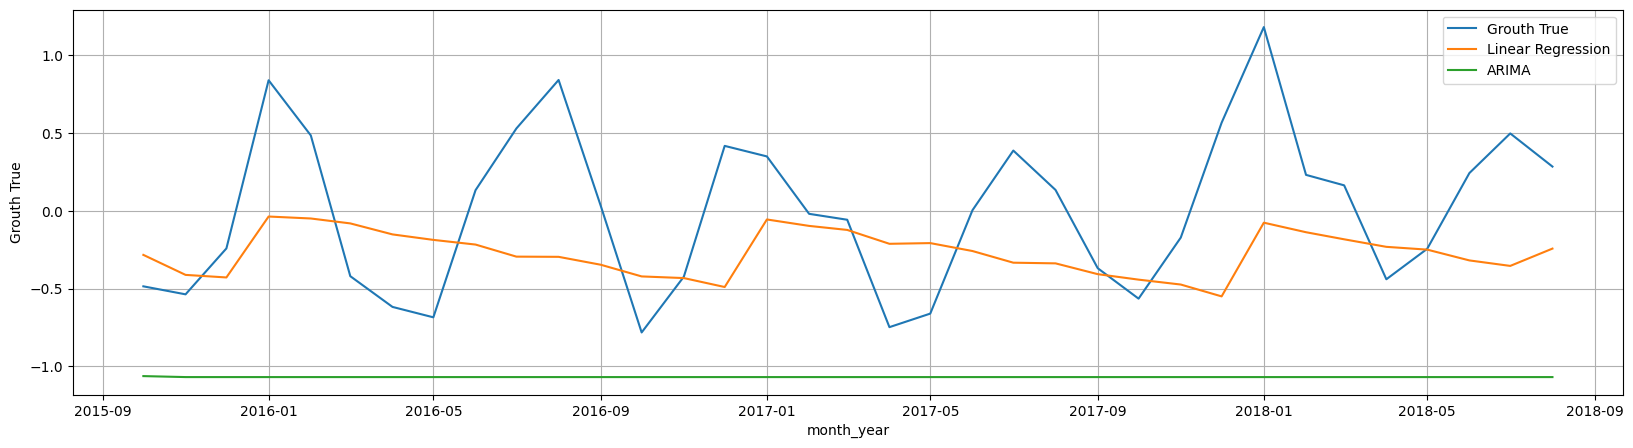

In [13]:
plt.figure(figsize = (20, 5))

sns.lineplot(data = gt_df, x = 'month_year', y = 'Grouth True', label = 'Grouth True')
sns.lineplot(data = lr_df, x = 'month_year', y = 'Linear Regression', label = 'Linear Regression')
sns.lineplot(data = arima_df, x = 'month_year', y = 'ARIMA', label = "ARIMA")

plt.legend()
plt.grid(True)
plt.show()